In [225]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings(action = 'ignore')

rankings = pd.read_csv('./worldCupData/fifaRanking2020-10-06.csv', encoding='windows-1252')
matches = pd.read_csv('./worldCupData/results.csv', encoding='windows-1252')
groups = pd.read_csv('./worldCupData/Qatar2022-teams.csv')

In [226]:
rankings = rankings.replace({"IR Iran": "Iran"})
rankings = rankings.replace({"Korea Republic": "South Korea"})
rankings['rank_date'] = pd.to_datetime(rankings['rank_date'])
matches['date'] = pd.to_datetime(matches['date'])
matches = matches.replace({"United States": "USA"})

In [227]:
rankings.head()

,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation,rank_date
0,164,Belize,BLZ,110.0,92.0,-3,CONCACAF,2013-01-17
1,163,Hong Kong,HKG,111.0,112.0,0,AFC,2013-01-17
2,120,Kuwait,KUW,276.0,281.0,3,AFC,2013-01-17
3,153,Faroe Islands,FRO,151.0,151.0,0,UEFA,2013-01-17
4,152,Palestine,PLE,154.0,152.0,0,AFC,2013-01-17


In [228]:
country_list = groups['Team'].values.tolist()
country_list = sorted(country_list)
# country_list

In [229]:
avgRanking = rankings.groupby(['country_full']).mean()
avgRanking = avgRanking.reset_index()

In [230]:
matches.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'country', 'neutral'],
      dtype='object')

In [231]:
# Different number of data
home_offense = matches.groupby(['home_team']).mean()['home_score'].fillna(0)
len(home_offense)

283

In [232]:
# Different number of data
away_offense = matches.groupby(['away_team']).mean()['away_score'].fillna(0)
len(away_offense)

278

Different number of data <br>
so extract countries which join the 2022 Qatar World Cup <br><br>
Countries: ['Senegal',
 'Qatar',
 'Netherlands',
 'Ecuador',
 'Iran',
 'England',
 'USA',
 'Wales',
 'Argentina',
 'Saudi Arabia',
 'Mexico',
 'Poland',
 'Denmark',
 'Tunisia',
 'France',
 'Australia',
 'Germany',
 'Japan',
 'Spain',
 'Costa Rica',
 'Morocco',
 'Croatia',
 'Belgium',
 'Canada',
 'Switzerland',
 'Cameroon',
 'Brazil',
 'Serbia',
 'Uruguay',
 'South Korea',
 'Portugal',
 'Ghana']

In [233]:
home = home_offense.to_frame().reset_index()
away = away_offense.to_frame().reset_index()

In [234]:
home = home[home['home_team'].isin(country_list)].reset_index()
home = home.drop(['index'], axis = 1)
#home

In [235]:
away = away[away['away_team'].isin(country_list)].reset_index()
away = away.drop(['index'], axis = 1)
# away

In [236]:
wc_score = pd.DataFrame()
wc_score['country_name'] = country_list
wc_score['offense_score'] = round((home['home_score'] * 0.3 + away['away_score'] * 0.7), 2) # Most gmaes are away game so I weighted more in away_score
# wc_score

In [237]:
home_diffense = matches.groupby(['home_team']).mean()['away_score'].fillna(0)
away_diffense = matches.groupby(['away_team']).mean()['home_score'].fillna(0)
home = home_diffense.to_frame().reset_index()
away = away_diffense.to_frame().reset_index()
home = home[home['home_team'].isin(country_list)].reset_index()
home = home.drop(['index'], axis = 1)
away = away[away['away_team'].isin(country_list)].reset_index()
away = away.drop(['index'], axis = 1)
wc_score['diffense_score'] = round(home['away_score'] * 0.3 + away['home_score'] * 0.7, 2) # most games are away
wc_score['GD'] = (wc_score['offense_score'] - wc_score['diffense_score']) # Goals Difference
# wc_score

In [238]:
avgRanking = avgRanking[['country_full', 'rank']]
avgRanking.head()

,country_full,rank
0,Afghanistan,146.207921
1,Albania,56.524752
2,Algeria,37.930693
3,American Samoa,190.396040
4,Andorra,173.128713


In [239]:
avgRank = avgRanking[avgRanking['country_full'].isin(country_list)].reset_index()
avgRank = avgRank.drop(['index'], axis = 1)
# avgRank

In [240]:
matches['score_difference_home'] = matches['home_score'] - matches['away_score']
matches['score_difference_away'] = matches['away_score'] - matches['home_score']
matches['home win'] = ((matches['score_difference_home'] > 0) & (matches['tournament'] != 'Friendly'))
matches['away win'] = ((matches['score_difference_away'] > 0) & (matches['tournament'] != 'Friendly'))
matches = matches[(matches['home_team'].isin(country_list)) | matches['away_team'].isin(country_list)]
# matches

In [241]:
winRate = {'country' : [], 'winrate': []}
for i in country_list:
    count = matches[(matches['home_team'] == i) | (matches['away_team'] == i) == True]
    winRate['country'].append(i)
    winRate['winrate'].append((len(count[count['home win']] == True) + len(count[count['away win']] == True)) / len(count))
    
winRate = pd.DataFrame(winRate)
#winRate

In [242]:
curRank = rankings[rankings['country_full'].isin(country_list)]
curRank = curRank.loc[curRank['rank_date'] == '2022-10-06'][['country_full', 'rank']]
curRank = curRank.sort_values('country_full')
wc_score['current_rank']= curRank['rank'].values.tolist()
wc_score['avgRank'] = round(avgRank['rank'], 2)
wc_score['winRate'] = round(winRate['winrate'], 2)
wc_score = wc_score[['country_name', 'current_rank', 'avgRank', 'GD', 'winRate']]
wc_score = wc_score.sort_values('current_rank').reset_index().drop(['index'], axis = 1)
wc_score

,country_name,current_rank,avgRank,GD,winRate
0,Brazil,1,5.06,1.63,0.47
1,Belgium,2,4.49,1.40,0.65
2,Argentina,3,4.47,0.97,0.49
3,France,4,9.69,0.86,0.47
4,England,5,9.68,1.28,0.54
5,Spain,7,6.72,1.18,0.55
6,Netherlands,8,14.15,0.98,0.54
7,Portugal,9,6.43,1.05,0.53
8,Denmark,10,23.78,0.75,0.51
9,Germany,11,5.98,1.17,0.56


In [243]:
corr = wc_score.corr()
corr.style.background_gradient()

,current_rank,avgRank,GD,winRate
current_rank,1.000000,0.827994,-0.675269,-0.299605
avgRank,0.827994,1.000000,-0.502896,-0.313125
GD,-0.675269,-0.502896,1.000000,0.383654
winRate,-0.299605,-0.313125,0.383654,1.000000


Conclusion of this Data Frame: 

In [244]:
# I want to have the ranks for every day 
rankings = rankings.set_index(['rank_date'])\
            .groupby(['country_full'], group_keys=False)\
            .resample('D').first()\
            .fillna(method='ffill')\
            .reset_index()

# join the ranks
matches = matches.merge(rankings, 
                        left_on=['date', 'home_team'], 
                        right_on=['rank_date', 'country_full'])
matches = matches.merge(rankings, 
                        left_on=['date', 'away_team'], 
                        right_on=['rank_date', 'country_full'], 
                        suffixes=('_home', '_away'))

In [245]:
matches.tail().columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'country', 'neutral', 'score_difference_home',
       'score_difference_away', 'home win', 'away win', 'rank_date_home',
       'rank_home', 'country_full_home', 'country_abrv_home',
       'total_points_home', 'previous_points_home', 'rank_change_home',
       'confederation_home', 'rank_date_away', 'rank_away',
       'country_full_away', 'country_abrv_away', 'total_points_away',
       'previous_points_away', 'rank_change_away', 'confederation_away'],
      dtype='object')

In [246]:
matches['score_diff'] = matches['home_score'] - matches['away_score']
matches['win'] = matches['score_diff'] > 0 # draw is not win
matches['is_stake'] = matches['tournament'] != 'Friendly'
matches['rank_diff'] = matches['rank_home'] - matches['rank_away']
matches['average_rank'] = (matches['rank_home'] + matches['rank_away'])/2
matches['point_diff'] = matches['total_points_home'] - matches['total_points_away']

In [247]:
# matches

## 3. Modeling

In [248]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from matplotlib import pyplot as plt

In [249]:
from xgboost import XGBClassifier
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC

In [250]:
X, y = matches.loc[:,['average_rank', 'rank_diff', 'point_diff', 'is_stake']], matches['win']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state = 42)
acc_score = {'model_name' : [], 'score': []}

In [251]:
clf = linear_model.LogisticRegression(random_state = 42, max_iter = 1000)
clf.fit(X_train, y_train)
clf_acc = clf.score(X_test, y_test)
acc_score['model_name'].append('logistic regression')
acc_score['score'].append(clf_acc)

In [252]:
xgb = XGBClassifier(n_estimators = 100, learning_rate = 0.1)
xgb.fit(X_train, y_train)
xgb_acc = xgb.score(X_test, y_test)
acc_score['model_name'].append('XGB')
acc_score['score'].append(xgb_acc)

In [253]:
gbdt = GradientBoostingClassifier(random_state = 42)
gbdt.fit(X_train, y_train)
gbdt_acc = gbdt.score(X_test, y_test)
acc_score['model_name'].append('GBDT')
acc_score['score'].append(gbdt_acc)

In [254]:
ada = AdaBoostClassifier(random_state = 42)
ada.fit(X_train, y_train)
ada_acc = ada.score(X_test, y_test)
acc_score['model_name'].append('ADA')
acc_score['score'].append(ada_acc)

In [255]:
acc_score = pd.DataFrame(acc_score)

In [256]:
acc_score = acc_score.sort_values(['score'], ascending = False)

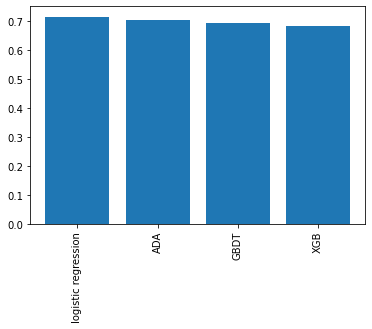

In [257]:
plt.bar(acc_score['model_name'], acc_score['score'])
plt.xticks(rotation = 90)
plt.show()

best accuracy is lositic regression for this data

### 3.1 Explanation of this graph: 

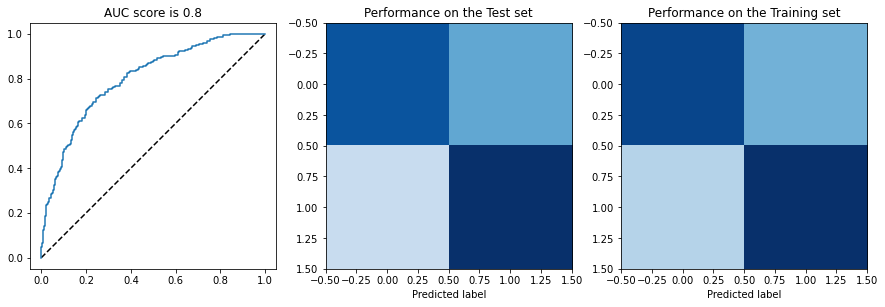

In [258]:
logreg = linear_model.LogisticRegression()

features = PolynomialFeatures(degree=2)
model = Pipeline([
    ('polynomial_features', features),
    ('logistic_regression', logreg)
])
model = model.fit(X_train, y_train)

# figures 
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr)
ax.set_title('AUC score is {0:0.2}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:,1])))
ax.set_aspect(1)

ax = plt.subplot(1,3,2)
cm = confusion_matrix(y_test, model.predict(X_test))
ax.imshow(cm, cmap='Blues', clim = (0, cm.max())) 

ax.set_xlabel('Predicted label')
ax.set_title('Performance on the Test set')

ax = plt.subplot(1,3,3)
cm = confusion_matrix(y_train, model.predict(X_train))
ax.imshow(cm, cmap='Blues', clim = (0, cm.max())) 
ax.set_xlabel('Predicted label')
ax.set_title('Performance on the Training set')
pass

### 3.2Conclusion of this performance: 

Stakes distribution in the wrong predictions
True     0.628571
False    0.371429
Name: is_stake, dtype: float64
Stakes distribution overall
True     0.672328
False    0.327672
Name: is_stake, dtype: float64


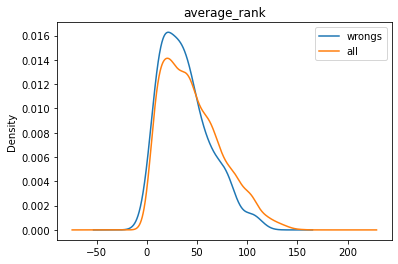

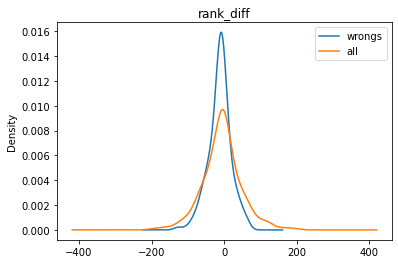

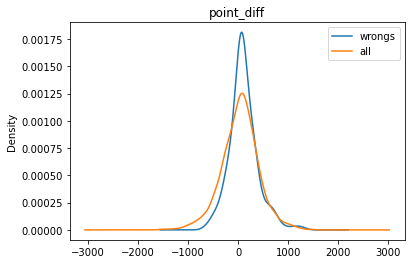

In [259]:
features = ['average_rank', 'rank_diff', 'point_diff']
wrongs = y_test != model.predict(X_test)

for feature in features:
    plt.figure()
    plt.title(feature)
    X_test.loc[wrongs, feature].plot.kde()
    X.loc[:, feature].plot.kde()
    plt.legend(['wrongs', 'all'])
    
print("Stakes distribution in the wrong predictions")
print(X_test.loc[wrongs, 'is_stake'].value_counts() / wrongs.sum())
print("Stakes distribution overall")
print(X['is_stake'].value_counts() / X.shape[0])

## 4. Simulation

In [260]:
wc_score.set_index('country_name')

,current_rank,avgRank,GD,winRate
country_name,,,,
Brazil,1,5.06,1.63,0.47
Belgium,2,4.49,1.40,0.65
Argentina,3,4.47,0.97,0.49
France,4,9.69,0.86,0.47
England,5,9.68,1.28,0.54
Spain,7,6.72,1.18,0.55
Netherlands,8,14.15,0.98,0.54
Portugal,9,6.43,1.05,0.53
Denmark,10,23.78,0.75,0.51


In [261]:
from itertools import combinations
# let's define a small margin when we safer to predict draw then win
margin = 0.05
groups['points'] = 0
groups['total_prob'] = 0
groups = groups.set_index('Team')
opponents = ['First match \nagainst', 'Second match\n against', 'Third match\n against']

In [262]:
for group in set(groups['Group']):
    print('-----------Group {}-----------'.format(group))
    for home, away in combinations(groups.query('Group == "{}"'.format(group)).index, 2):
        print("{} vs. {}: ".format(home, away), end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
        row = row.fillna(0)
        #home_rank = wc_score.loc[home, 'current_rank']
        #home_avg = wc_score.loc[home, 'avgRank']
        #opp_rank = wc_score.loc[away, 'current_rank']
        #opp_avg = wc_score.loc[away, 'avgRank']
        #row['avg_rank'] = (home_rank + opp_rank) / 2
        #row['rank_diff'] = home_rank - opp_rank
        #row['avg_diff'] = home_avg - opp_avg
        
        home_win_prob = model.predict_proba(row)[:,1][0]
        groups.loc[home, 'total_prob'] += home_win_prob
        groups.loc[away, 'total_prob'] += 1-home_win_prob
        
        points = 0
        if home_win_prob <= 0.5 - margin:
            print("{} wins with {:.2f}".format(away, 1-home_win_prob))
            groups.loc[away, 'points'] += 3
        if home_win_prob > 0.5 - margin:
            points = 1
        if home_win_prob >= 0.5 + margin:
            points = 3
            groups.loc[home, 'points'] += 3
            print("{} wins with {:.2f}".format(home, home_win_prob))
        if points == 1:
            print("Draw")
            groups.loc[home, 'points'] += 1
            groups.loc[away, 'points'] += 1

-----------Group A-----------
Senegal vs. Qatar: Draw
Senegal vs. Netherlands: Draw
Senegal vs. Ecuador: Draw
Qatar vs. Netherlands: Draw
Qatar vs. Ecuador: Draw
Netherlands vs. Ecuador: Draw
-----------Group G-----------
Switzerland vs. Cameroon: Draw
Switzerland vs. Brazil: Draw
Switzerland vs. Serbia: Draw
Cameroon vs. Brazil: Draw
Cameroon vs. Serbia: Draw
Brazil vs. Serbia: Draw
-----------Group F-----------
Morocco vs. Croatia: Draw
Morocco vs. Belgium: Draw
Morocco vs. Canada: Draw
Croatia vs. Belgium: Draw
Croatia vs. Canada: Draw
Belgium vs. Canada: Draw
-----------Group D-----------
Denmark vs. Tunisia: Draw
Denmark vs. France: Draw
Denmark vs. Australia: Draw
Tunisia vs. France: Draw
Tunisia vs. Australia: Draw
France vs. Australia: Draw
-----------Group B-----------
Iran vs. England: Draw
Iran vs. USA: Draw
Iran vs. Wales: Draw
England vs. USA: Draw
England vs. Wales: Draw
USA vs. Wales: Draw
-----------Group E-----------
Germany vs. Japan: Draw
Germany vs. Spain: Draw
Germ